Preprocessing

In [21]:
from PIL import Image
from pathlib import Path
import numpy as np

In [22]:
def convert_tif_png(tif_filename: Path, out_folder:Path):
    # Open mask with PIL 
    arr_tif = np.array(Image.open(tif_filename))

    # change values from 255 to 1
    im = Image.fromarray(np.where(arr_tif==255, 1, 0))

    im.save(out_folder/tif_filename.with_suffix('.png').name)
    
    return im

In [23]:
mask_path = Path('../data/segmentation_v1/train/masks/data')
for img in mask_path.iterdir():
    convert_tif_png(img, mask_path)

#### 这一步绝对不能少

# 1. Data Loader

In [2]:
from fastai.vision import *

In [3]:
from pathlib import Path

path_data = Path('../data/segmentation_v1/train/')

path_img = path_data/'images/data'
path_lbl = path_data/'masks/data'

# get images and labels filenames
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

print(len(img_names), len(lbl_names))

1553 1553


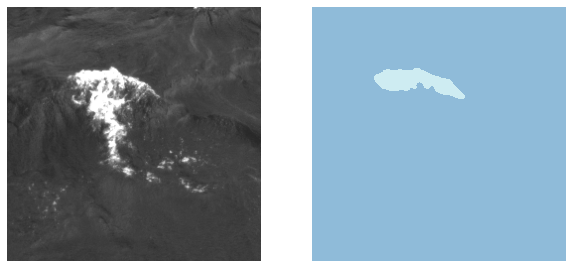

In [28]:
import matplotlib.pyplot as plt

fname_img = Path('../data/segmentation_v1/train/images/data/2011_10_01_14_18_00_000024.png')
fname_lbl = Path('../data/segmentation_v1/train/masks/data/2011_10_01_14_18_00_000024.png')

img = open_image(fname_img)
mask = open_mask(fname_lbl)

fig, ax = plt.subplots(1,2, figsize=(10,6))

img.show(ax[0])
mask.show(ax[1])

In [29]:
def get_mask_fn(path_img: Path):
    mask_name = path_img.name
    return path_img.parent.parent.parent/("masks/data/" + mask_name)

In [30]:
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_mask_fn, classes = ['Non-active', 'Active']))

data = (src.transform(get_transforms(flip_vert=True), size=256, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

data

e:\Anaconda\envs\fastai_V1\lib\site-packages\fastai\vision\transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


ImageDataBunch;

Train: LabelList (1243 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: segmentation_v1\train\images\data;

Valid: LabelList (310 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: segmentation_v1\train\images\data;

Test: None

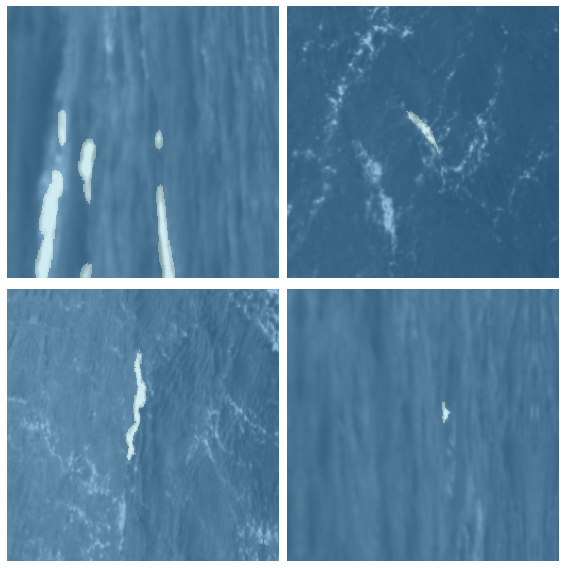

In [31]:
data.show_batch(4)

# 2. Model

In [32]:
# create a simple metric to verify the results
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

# weight decay
wd = 1e-2
#learning rate
lr=1e-3
# load the model, according to the data parameters (resolution, for example)
learn = unet_learner(data, models.resnet34, metrics=acc_metric, wd=wd)
#train the model with 3 epochs
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,acc_metric,time
0,0.029290,0.040406,0.984521,01:36
1,0.021174,0.024637,0.991035,01:31


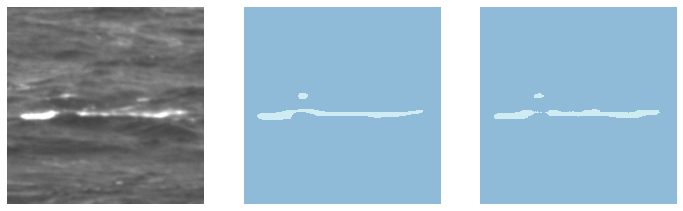

In [33]:
#save the model
learn.save('active_whitecaps_Resnet34')

# select one image from the validation dataset
img = learn.data.valid_ds.x[22]
mask = learn.data.valid_ds.y[22]
pred = learn.predict(img)[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

img.show(ax[0])
mask.show(ax[1])
pred.show(ax[2])

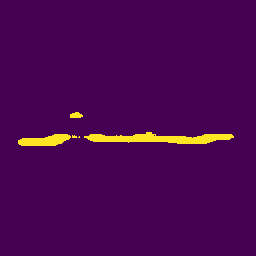

In [34]:
prediction = learn.predict(img)
prediction[0]

epoch,train_loss,valid_loss,acc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


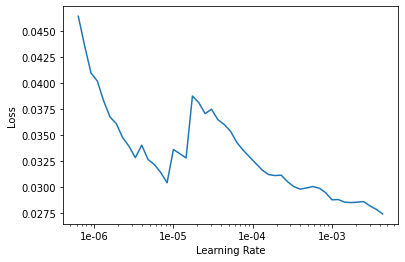

In [35]:
lr_find(learn)
learn.recorder.plot()